# Data report for the acute neurotox dataset for MOE gapmers

This dataset was collected from various patents reporting the acute neurotoxicity of MOE gapmers. These are in vivo readouts from mice, known as functional observational battery (FOB) scores. The FOB score is an established methodology for assessing neurotoxicity in mice and rats. The scores range from 0 to 7, with 7 being the most toxic.

In [23]:
from oligogym.data import DatasetDownloader
from oligogym.features import KMersCounts
from oligogym.helm import helm2xna
from oligogym.models import RandomForestModel
from oligogym.metrics import regression_metrics
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Processed dataset

In [24]:
downloader = DatasetDownloader()
dataset = downloader.download("acute_neurotox_moe")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{[moe]([m5C])[sp].[moe]([m5C])p.[moe](G)p....,3,3.25,C9ORF72,COCCO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C...,CCGGCCCCTAGCGCGCGACT
1,RNA1{[moe]([m5C])[sp].[moe]([m5C])p.[moe](G)p....,4,4.25,C9ORF72,COCCO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C...,CCGGCCCCTAGCGCGCGACT
2,RNA1{[moe]([m5C])[sp].[moe]([m5C])p.[moe](G)p....,4,3.50,C9ORF72,COCCO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C...,CCGGCCCCTAGCGCGCGACT
3,RNA1{[moe]([m5C])[sp].[moe]([m5C])p.[moe](G)p....,2,2.00,C9ORF72,COCCO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C...,CCGGCCCCTAGCGCGCGACT
4,RNA1{[moe]([m5C])[sp].[moe](G)p.[moe](G)p.[moe...,4,4.00,C9ORF72,COCCO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C...,CGGCCCCTAGCGCGCGACT


## Features statistics

In [25]:
dataset.get_helm_stats()

,avg_nt_seq_len,combined_unique_monomers,avg_GC_content,avg_G_content,avg_C_content,avg_A_content,avg_TU_content,num_duplicates
0,18.651621,"[A, G, T, U, d, m5C, moe, p, sp]",40.747013,17.101861,32.196083,22.219714,37.033273,39


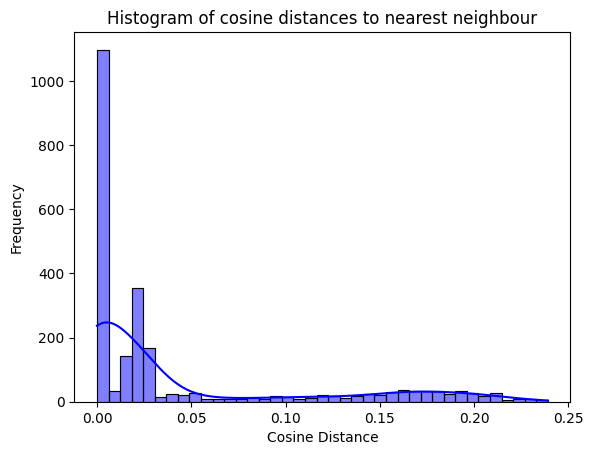

In [26]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(dataset.x)

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [27]:
number_similar_sequences = np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

684 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


In [28]:
unique_base_sequences = list(set([helm2xna(i).polymers['RNA1']['base'] for i in dataset.x]))
print(f"{len(unique_base_sequences)} ASOs have unique base sequences")

1680 ASOs have unique base sequences


In [29]:
unique_base_sequences_amongst_similar_helm= list(set([helm2xna(i).polymers['RNA1']['base'] for i in dataset.x[np.where(cosine_distances == 0)]]))
print(f"Amongst 700 highly similar sequences there are only {len(unique_base_sequences_amongst_similar_helm)} unique base sequences")

Amongst 700 highly similar sequences there are only 224 unique base sequences


In [30]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

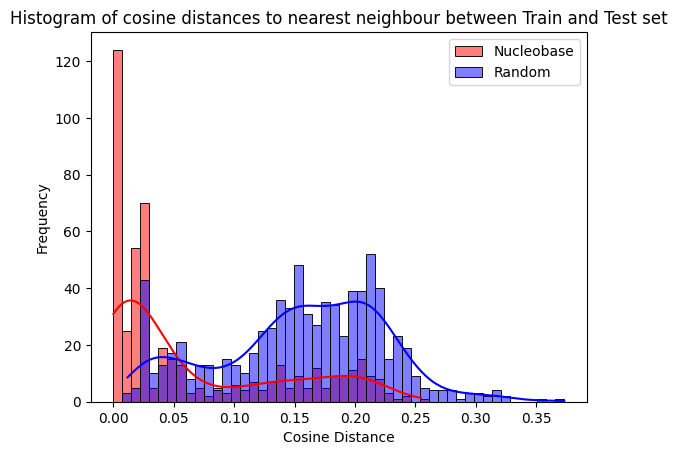

In [31]:
data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 50
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

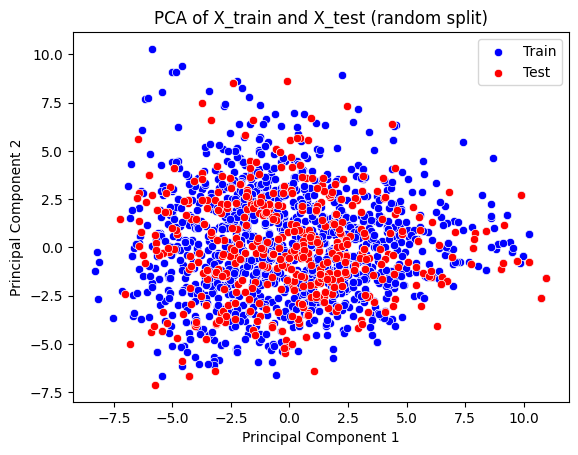

In [32]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (random split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

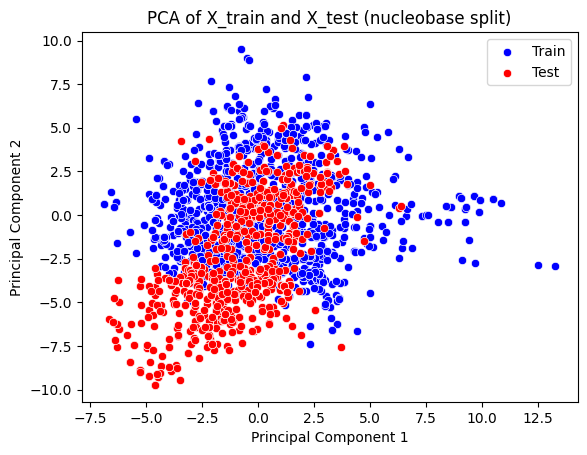

In [33]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (nucleobase split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

## Labels statistics

In [34]:
label_stats=dataset.get_label_stats()
label_stats

,nobs,minmax,mean,variance,skewness,kurtosis,num_zeros
0,2437,"(0, 7)",2.338531,4.728946,0.543529,-0.970975,695


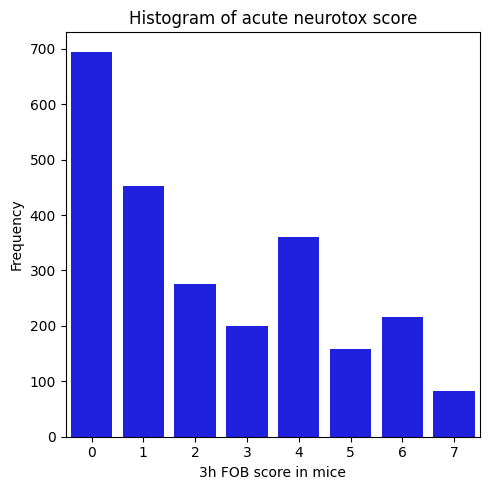

In [35]:
fig, axs = plt.subplots(figsize=(5, 5))

sns.barplot(dataset.data.y.value_counts(), ax=axs, color='blue')
axs.set_title('Histogram of acute neurotox score')
axs.set_xlabel('3h FOB score in mice')
axs.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Clustering analysis

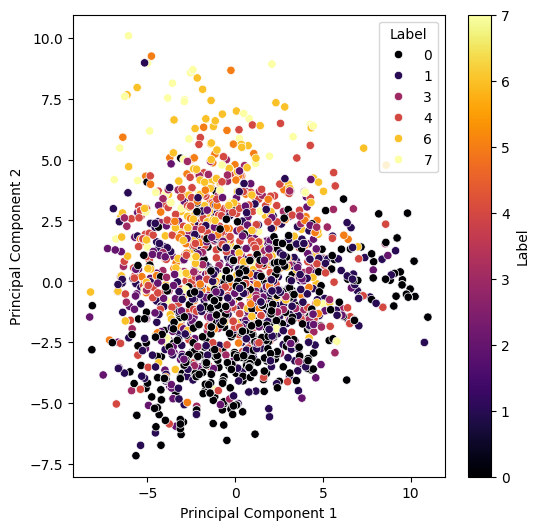

In [36]:
featurizer = KMersCounts(k=[1, 2, 3])
X_kmers = featurizer.fit_transform(dataset.x)

pca = PCA(n_components=2)
X_kmers_pca = pca.fit_transform(X_kmers)

fig, ax = plt.subplots(1 ,1, figsize=(6, 6))
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=dataset.y, ax=ax, palette='inferno')
norm = plt.Normalize(dataset.y.min(), dataset.y.max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Label')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend(title="Label")

plt.show()

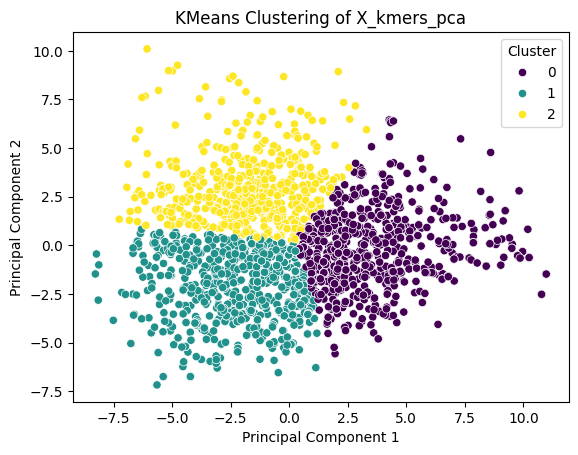

In [37]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_kmers_pca)

# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=clusters, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Let's figure out which features differ the most between the different clusters.

In [38]:
cluster_means = X_kmers.groupby(clusters).mean()
feature_differences = cluster_means.diff().abs().iloc[1]
sorted_feature_differences = feature_differences.sort_values(ascending=False)
print(sorted_feature_differences.head(10))

T      3.473769
TT     2.768596
A      2.039305
TTT    1.622560
C      1.233680
CA     0.999202
AC     0.761671
AA     0.732474
TCT    0.560925
GT     0.550867
Name: 1, dtype: float64


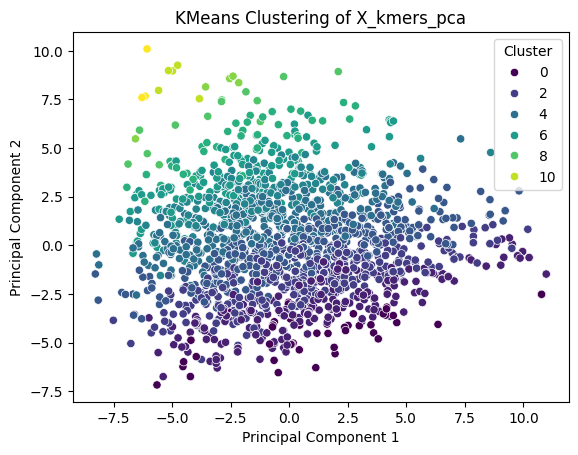

In [39]:
# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=X_kmers['G'].values, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

We can also do this by looking at the features that are most important for classifying the clusters.

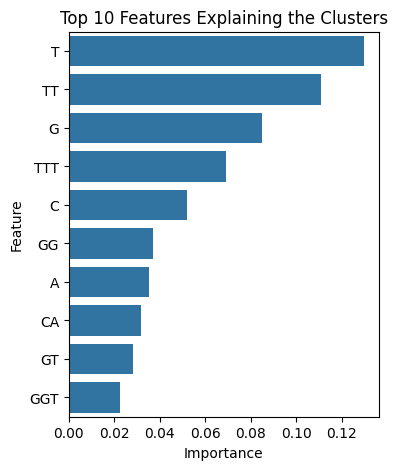

In [40]:
importances = RandomForestClassifier(random_state=42).fit(X_kmers, clusters).feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_kmers.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(4, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Features Explaining the Clusters')
plt.show()

# Predictability analysis

In [41]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

model = RandomForestModel(task="regression")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
metrics_train = regression_metrics(y_train, y_pred_train)
metrics = regression_metrics(y_test, y_pred)
print(metrics_train)
print(metrics)


{'r2_score': 0.8807370952417033, 'root_mean_squared_error': 0.7485887911239145, 'mean_absolute_error': 0.5464239038795164, 'pearson_correlation': 0.9442850425006517, 'spearman_correlation': 0.9365693629815871}
{'r2_score': 0.4661291754954915, 'root_mean_squared_error': 1.6071037912734973, 'mean_absolute_error': 1.2010637839957823, 'pearson_correlation': 0.685596677776513, 'spearman_correlation': 0.6877800510176215}


## Recommendation for dataset

This dataset was originally collected by Peter Hagedorn from patent data. The dataset seem to have very similar base sequences when measured by k-mer frequency with kmer length 1 to 5. However the sequences are not all duplicates and the high similarity appears to come from tiling of the target gene. Because of the high sequence similarity, a nucleobase data split strategy is recommended. 

The labels of the dataset are Functional Observational Battery (FOB) scores calculate at 3hr. These are behavioral score for assessing neurotoxic potential of compound in rodents. The dataset collected by Peter contain scores calculate from both mice and rat. Because it is currently unclear whether the score from two species can be combined, the rat score (217 compounds) are dropped from the dataset. The raw score range around the main categorical score 0 to 7 so rounded scores are recommended to be used as label for multiclass classification model. Although, these labels have clear ordinal relationship with decreasing observation frequency for more toxic class, so a regression, particularly oridnal regression (ranking) model could also be used.

The dataset contain 39 exact HELM duplicates and should be dropped before model training.

In [42]:
downloader=DatasetDownloader()
dataset=downloader.download("acneuTox_moe")
cleaned_dataset = dataset.data.drop_duplicates(subset='x', keep='first')

print(f"{len(dataset.data)-len(cleaned_dataset)} datapoints removed")

39 datapoints removed
